In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
dict_img_position = {
    'main':[0, 200],
    'ht':[200, 650],
    'loss':[650, 920],
    'overall_results':[930, 1150]}

In [24]:
from modules.summarizing_utils.common_filter_results_methods import get_img_list
from modules.summarizing_utils.filter_results_utils import get_available_attr
from modules.summarizing_utils.filter_results_utils import filter_results

from modules.summarizing_utils.save_imgs import save_imgs2pdf
from modules.summarizing_utils.sorting_methods import sort_by_attr_values

from modules.summarizing_utils.heatmaps import get_override_dict_list
from modules.summarizing_utils.heatmaps import quantitative_results_HEATMAPS

## Obtain attribute dictionary

In [25]:
import glob

In [34]:
modes = ['L1Loss', 'MSE', 'SSIM', 'SSIM11', 'SSIM5', 'last_converged']
interested_modes = ['L1Loss', 'MSE', 'SSIM5', 'SSIM11']

#exp_set_dir = 'figs/confocalv2'
exp_set_dir = '/n/holyscratch01/wadduwage_lab/uom_Udith/results/aim2/important/exp_set1'

for dir_ in glob.glob(f'{exp_set_dir}/*'):
    if dir_.split('/')[-1]=='heatmaps' or dir_.split('/')[-1]=='_results_summaries':continue
    for img_dir in glob.glob(f'{dir_}/*.jpg'):
        if '150_' in img_dir:break
    else:
        print(f'Incompleted exp : {dir_}')
else:
    print('All exps are completed')
print('\n\n')

mode= interested_modes[0]
img_list = get_img_list(img_dir = exp_set_dir, mode=mode)
print('img_list length : ', len(img_list))
dict_ = get_available_attr(img_list)
interested_imgs = filter_results(img_list, dict_)
print(f'available keys : {list(dict_img_position.keys())}')

dict_

Incompleted exp : /n/holyscratch01/wadduwage_lab/uom_Udith/results/aim2/important/exp_set1/name(confocal)@rotation_lambda(10.0)@lambda_scale_factor(3)@T(8)@lr_H(1.0)@H_init(randn_FourierBased)@img_size(256)@num_samples_train(3000)@upsample_net(learnable_transpose_conv)
Incompleted exp : /n/holyscratch01/wadduwage_lab/uom_Udith/results/aim2/important/exp_set1/name(confocal)@rotation_lambda(10.0)@lambda_scale_factor(3)@T(2)@lr_H(0.0)@H_init(randn_FourierBased)@img_size(256)@num_samples_train(3000)@upsample_net(learnable_transpose_conv)
Incompleted exp : /n/holyscratch01/wadduwage_lab/uom_Udith/results/aim2/important/exp_set1/name(confocal)@rotation_lambda(10.0)@lambda_scale_factor(4)@T(1)@lr_H(1.0)@H_init(randn_FourierBased)@img_size(256)@num_samples_train(3000)@upsample_net(learnable_transpose_conv)
Incompleted exp : /n/holyscratch01/wadduwage_lab/uom_Udith/results/aim2/important/exp_set1/name(confocal)@rotation_lambda(10.0)@lambda_scale_factor(3)@T(4)@lr_H(0.0)@H_init(randn_FourierBase

{'name': ['confocal'],
 'rotation_lambda': ['10.0'],
 'lambda_scale_factor': ['1', '2', '3', '4'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'lr_H': ['0.0', '1.0'],
 'H_init': ['randn_FourierBased'],
 'img_size': ['256'],
 'num_samples_train': ['3000'],
 'upsample_net': ['learnable_transpose_conv']}

## Save qualitative results and Quantitative results (HEATMAPS) to PDF

In [20]:
def save_HEATMAPS(mode, img_list, exp_set_dir= None): ## CHANGE THIS 
    print(mode)    
    plot_vars_dict ={
                     'T': ['1', '2', '4', '8', '16', '32'], #
                     'lambda_scale_factor': ['7']
    }
    
    all_overrides_dict = {'rotation_lambda': ['10.0'], #'10000.0'
                          'img_size': ['256'],
                          'num_samples_train': ['3000']
                          }
    
    plot_label_dict= None #skip notation: 'SKIPZE100S1' if needed
     

    low_lr_H, high_lr_H= '0.0', '1.0'

    '''
    plot_vars_dict = {
         'interested_attr1': ['name11', 'name12'],
         'interested_attr2': ['name21', 'name22']}
    
    all_overrides_dict = {'attr1': ['val11', 'val12'],
                          'attr2': ['val21', 'val22'] }
    
    plot_label_dict= {'interested_attr1': ['name11', 'name12'],
                 'interested_attr2': ['name21', 'name22']}
    '''
    
    overrides_dict_list = get_override_dict_list(all_overrides_dict) ## obtain all combinations of override dicts
    quantitative_results_HEATMAPS(img_list, plot_vars_dict, overrides_dict_list, mode, save_dir = exp_set_dir, low_lr_H= low_lr_H, high_lr_H= high_lr_H, show_interested_img_names= False, plot_label_dict= plot_label_dict)

1/12 : figs/confocalv2/rotation_lambda(10.0)@lambda_scale_factor(7)@T(1)@lr_H(0.0)@name(confocal)@H_init(randn_FourierBased)@img_size(256)@num_samples_train(3000)@upsample_net(learnable_transpose_conv)/150_L1Loss(0.0557328)_MSE(0.0123919)_SSIM11(0.5539569)_SSIM5(0.5649227).jpg
len img dirs : 12
img_list length :  12
12 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']
qualitative results saved : figs/confocalv2/_results_summaries/results_MSE_confocalv2.pdf
MSE
attr_dict_highlrH : {'T': ['1', '2', '4', '8', '16', '32'], 'lambda_scale_factor': ['7'], 'lr_H': ['1.0']}
attr_dict_lowlrH : {'T': ['1', '2', '4', '8', '16', '32'], 'lambda_scale_factor': ['7'], 'lr_H': ['0.0']}
ploting heatmaps ... 
override dict : {'rotation_lambda': '10.0', 'img_size': '256', 'num_samples_train': '3000'}
6 images are found !!!
6 images are found !!!
******************* WARNING !!! :: m_inc_method :: inc_m_class(epoch_threshold= 80, epoch_steps= 10) is assumed !!! ****************

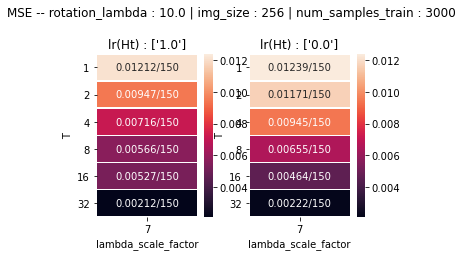

ploting heatmaps finished !!!
quantitative results saved : figs/confocalv2/heatmaps/heatmaps_confocalv2.pdf
1/12 : figs/confocalv2/rotation_lambda(10.0)@lambda_scale_factor(7)@T(1)@lr_H(0.0)@name(confocal)@H_init(randn_FourierBased)@img_size(256)@num_samples_train(3000)@upsample_net(learnable_transpose_conv)/150_L1Loss(0.0557328)_MSE(0.0123919)_SSIM11(0.5539569)_SSIM5(0.5649227).jpg
len img dirs : 12
img_list length :  12
12 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']
qualitative results saved : figs/confocalv2/_results_summaries/results_SSIM11_confocalv2.pdf
SSIM11
attr_dict_highlrH : {'T': ['1', '2', '4', '8', '16', '32'], 'lambda_scale_factor': ['7'], 'lr_H': ['1.0']}
attr_dict_lowlrH : {'T': ['1', '2', '4', '8', '16', '32'], 'lambda_scale_factor': ['7'], 'lr_H': ['0.0']}
ploting heatmaps ... 
override dict : {'rotation_lambda': '10.0', 'img_size': '256', 'num_samples_train': '3000'}
6 images are found !!!
6 images are found !!!
******************

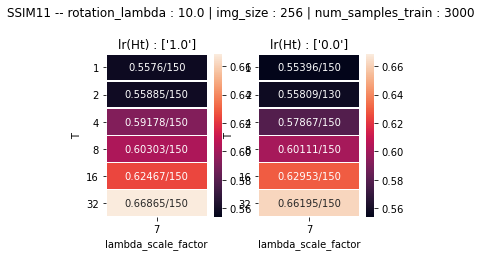

ploting heatmaps finished !!!
quantitative results saved : figs/confocalv2/heatmaps/heatmaps_confocalv2.pdf


In [21]:
import shutil, os

try:shutil.rmtree(f'{exp_set_dir}/_results_summaries')
except:pass

try:shutil.rmtree(f'{exp_set_dir}/heatmaps')
except:pass

os.mkdir(f'{exp_set_dir}/_results_summaries')

for mode in ['MSE', 'SSIM11']:#, 'last_converged_MSE']:#interested_modes:
    img_list = get_img_list(img_dir = exp_set_dir, mode=mode)
    print('img_list length : ', len(img_list))

    dict_ = get_available_attr(img_list)
    interested_imgs = filter_results(img_list, dict_)
    print(f'available keys : {list(dict_img_position.keys())}')

    #show_results('main', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('loss', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('ht', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('overall_results', dict_img_position, interested_imgs,  sort_by_attr_values)

    exp_set_dir_name= exp_set_dir.split('/')[-1]
    img_pdf_filename = f'{exp_set_dir}/_results_summaries/results_{mode}_{exp_set_dir_name}.pdf'
    save_imgs2pdf(interested_imgs, sorting_function= sort_by_attr_values, pdf_filename=img_pdf_filename, attr_dict= dict_)
    print(f'qualitative results saved : {img_pdf_filename}')
    
    ## ABOVE attr_dict_highlrH, attr_dict_lowlrH -> ONLY CONTAIN KEYS: lr_H, interested_key1, interested_key2 || Other keys -> goes into override dicts !!!


    save_HEATMAPS(mode, img_list, exp_set_dir)

## Convert HEATMAP values to MATLAB format

In [ ]:
#exp_set_dir = 'figs/mnistv13'

print('exp_set_dir :',exp_set_dir) 
heatmap_zipped_dir = './heatmaps_mat_files.zip' #f'{exp_set_dir}/heatmaps/heatmaps_mat_files.zip'

In [ ]:
!rm -rf ./test
!rm $heatmap_zipped_dir

In [ ]:
#%%capture
from modules.summarizing_utils.numpy2mat import zip_heatmap_vals_matlab
zip_heatmap_vals_matlab(exp_set_dir=exp_set_dir, target_dir = heatmap_zipped_dir)

In [4]:
%%capture
!mkdir ./test
!unzip $heatmap_zipped_dir -d ./test

In [ ]:
!ls ./test

In [6]:
import os 
len(os.listdir('./test'))

192

In [7]:
!rm -rf ./test
!rm $heatmap_zipped_dir